In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned/cleaned_data.csv')

Mean of TradeValue: 181161.76987179488


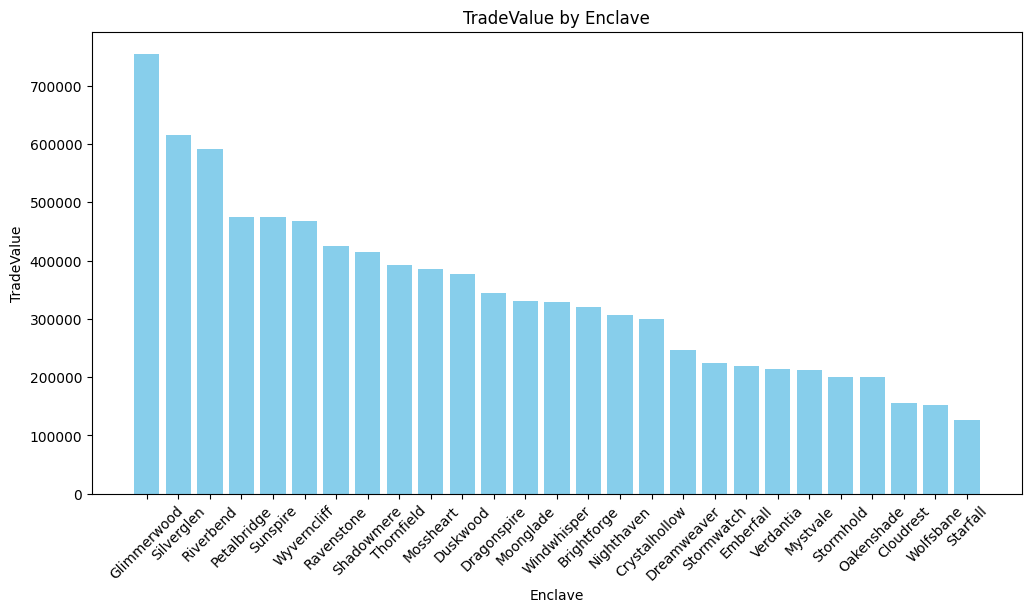

In [3]:
# Calculate the mean of the 'TradeValue' column
trade_value_mean = df['TradeValue'].mean()
print(f"Mean of TradeValue: {trade_value_mean}")

# Sort the 'TradeValue' column
sorted_trade_values = df.sort_values(by='TradeValue', ascending=False)

x = sorted_trade_values['Enclave']
y = sorted_trade_values['TradeValue']

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='skyblue')
plt.xlabel('Enclave')
plt.ylabel('TradeValue')
plt.title('TradeValue by Enclave')
plt.xticks(rotation=45)
plt.show()

<h1> Step 1: Define Constants

In [19]:
# Annual Income = $30,000
# Monthly Income = $30,000 / 12 = $2,500
# Affordability Threshold = 30% of $2,500 = $750 per month
# Loan Parameters:
#     Downpayment = 20% of TradeValue
#     Loan Amount = TradeValue - Downpayment
#     Interest Rate = 4% annually → 0.00333 monthly
#     Loan Term = 30 years (360 payments)


# Constants
Monthly_income = 2500
Affordability_threshold = 0.3 * Monthly_income
Interest_rate = 0.00333
Loan_term = 30 * 12

# Function to calculate values per row
def calculate_loans(row):
    Downpayment = 0.2 * row['TradeValue']
    Loan_amount = row['TradeValue'] - Downpayment
    return pd.Series([Downpayment, Loan_amount], index=['Downpayment', 'LoanAmount'])

# Apply the calculate_loans function to each row of the dataframe
df[['Downpayment', 'LoanAmount']] = df.apply(calculate_loans, axis=1)
print(df[['Downpayment', 'LoanAmount']])


#monthly payment = ( loan * interest per month * (1+ interest rate per month) ^ total number of payments  ) / ((1 + monthly interest rate) ^ payments - 1)
def calculate_monthly_payments(row):
    monthly_payment = (row['LoanAmount'] * Interest_rate * (1 + Interest_rate) ** Loan_term) / ((1 + Interest_rate) ** Loan_term - 1)
    return monthly_payment

df['MonthlyPayment'] = df.apply(calculate_monthly_payments, axis=1)
print(df['MonthlyPayment'])

# Check if a home is considered affordable when the monthly payment is less or equal to 30% of the monthly available funds for the household
# Affordable is 1, not affordable is 0
def check_affordability(row):
    if row['MonthlyPayment'] <= Affordability_threshold:
        return 1
    else:
        return 0

df['Affordable'] = df.apply(check_affordability, axis=1)
print(df['Affordable'])


      Downpayment  LoanAmount
0         53900.0    215600.0
1         36980.0    147920.0
2         17400.0     69600.0
3         26000.0    104000.0
4         28800.0    115200.0
...           ...         ...
2335      29200.0    116800.0
2336      17650.0     70600.0
2337      36400.0    145600.0
2338      25600.0    102400.0
2339      17000.0     68000.0

[2340 rows x 2 columns]
0       1028.810255
1        705.851637
2        332.120565
3        496.272108
4        549.716797
           ...     
2335     557.351752
2336     336.892412
2337     694.780951
2338     488.637152
2339     324.485609
Name: MonthlyPayment, Length: 2340, dtype: float64
0       0
1       1
2       1
3       1
4       1
       ..
2335    1
2336    1
2337    1
2338    1
2339    1
Name: Affordable, Length: 2340, dtype: int64
